# **Creating all datasets**

In [126]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import math
import graphviz

In [127]:
from google.colab import drive
train = pd.read_csv("/content/drive/MyDrive/SISTEMAS INTELIGENTES/Datasets/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SISTEMAS INTELIGENTES/Datasets/test.csv")

In [128]:
#Create a copy of all train and test data and also combine them into a dataframe
trainn = train.copy()
testt = test.copy()
data = [train, test]

#Determine if the passanger had a cabin 
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#Combine SibSp and Parch into one single data to determine Family size and reduce info
for dataset in data:
    dataset['FS'] = dataset['SibSp'] + dataset['Parch'] + 1
for dataset in data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FS'] == 1, 'IsAlone'] = 1 

#Eliminate the NULL values  
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')  
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
for dataset in data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

#Reduce the names only to titles
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
for dataset in data:
    dataset['Title'] = dataset['Name'].apply(get_title)
for dataset in data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')  
dataset['Title'].value_counts()  

Mr        240
Miss       79
Mrs        72
Master     21
Other       6
Name: Title, dtype: int64

In [129]:
#Now we change data into number values
for dataset in data:
  dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1})
  dataset['Sex'] = dataset['Sex'].fillna(0)
  title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Other": 5}
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)
  dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
  dataset['Fare'] = dataset['Fare'].astype(int)
  dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [130]:
#Now we remove the continous values that we wont need or have a lot of missing data
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch'], axis = 1)
test  = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch'], axis = 1)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Has_Cabin,FS,IsAlone,Title
0,0,3,1,1,0,0,0,2,0,1
1,1,1,0,2,3,1,1,2,0,3
2,1,3,0,1,1,0,0,1,1,4
3,1,1,0,2,3,0,1,2,0,3
4,0,3,1,2,1,0,0,1,1,1


In [131]:
test

,Pclass,Sex,Age,Fare,Embarked,Has_Cabin,FS,IsAlone,Title
0,3,1,2,0,2,0,1,1,1
1,3,0,2,0,0,0,2,0,3
2,2,1,3,1,2,0,1,1,1
3,3,1,1,1,0,0,1,1,1
4,3,0,1,1,0,0,3,0,3
...,...,...,...,...,...,...,...,...,...
413,3,1,1,1,0,0,1,1,1
414,1,0,2,3,1,1,1,1,5
415,3,1,2,0,0,0,1,1,1
416,3,1,2,1,0,0,1,1,1


### **Decision Tree**

In [132]:
#Finally we define our dataframes to input for the decision tree
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

#Create the decision tree 
dt = tree.DecisionTreeClassifier(random_state=0,max_depth = 5)
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)

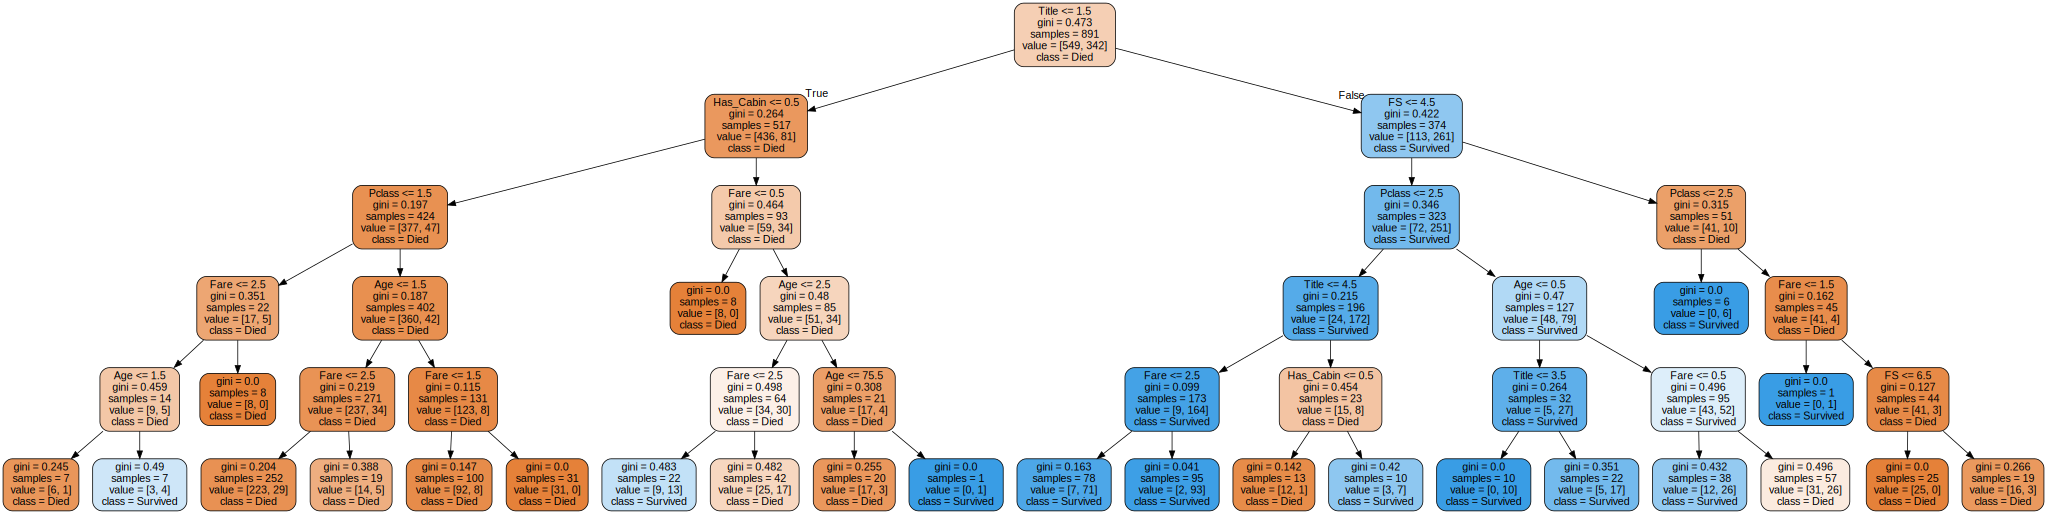

In [133]:
dot = tree.export_graphviz(decision_tree,
                              max_depth = 5,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
graph = graphviz.Source(dot)
graph

In [135]:
print("Today we're gonna determine if you could have been a survivor in the titanic")
print("Please enter the requested data")

print("Ticket Class: First class -1, Second class - 2, Third class - 3 ")
Class=float(input("Whats your ticket class? "))
print("Male-1, Female -0")
Gender=float(input("enter gender: "))
print("MR-1, Master-2, Mrs-3, Miss-4, Other-5")
Titl=float(input("What's your title? "))
Lonely=float(input("Are you traveling alone? Yes-1 No-0"))
print("If you traveling alone place 0, if not input number of people traveling with you (sibling, parents, children, etc")
Fam=float(input("How many people you traveling with? "))
print("Embarked:  S-0, C-1, Q-2")
Emba=float(input("Where you embark? "))
print("Fare: paid<8 - 0 , 8<paid>15 - 1 , 15<paid>31 - 2 , paid>31 - 3")
Paid=float(input("How much did you pay? "))
print("Age: Child(0-16) - 0, Young adult(16-32) - 1, Adult(32-48) - 2, Old(48-64) - 3")
Edad=float(input("What's your age? "))
Cab=float(input("Do you have a Cabin? Yes-1 No-0 "))


numpy_array=np.array([[Class,Gender,Edad,Paid,Emba,Cab,Fam,Lonely,Titl]])
new_df=pd.DataFrame(numpy_array,columns=['Class','Sex','Age','Fare','Embarked','HasCabin','FS','IsAlone','Title'])
prediction=dt.predict(new_df)
#prediction
if(prediction==1):
    print('Great News! You are one of the survivors of the titanic')
else:
     print('I´m sorry, you gonna be sleeping with the fishes forever')

print(" ")

Today we're gonna determine if you could have been a survivor in the titanic
Please enter the requested data
Ticket Class: First class -1, Second class - 2, Third class - 3 
Whats your ticket class? 3
Male-1, Female -0
enter gender: 0
MR-1, Master-2, Mrs-3, Miss-4, Other-5
What's your title? 4
Are you traveling alone? Yes-1 No-01
If you traveling alone place 0, if not input number of people traveling with you (sibling, parents, children, etc
How many people you traveling with? 0
Embarked:  S-0, C-1, Q-2
Where you embark? 1
Fare: paid<8 - 0 , 8<paid>15 - 1 , 15<paid>31 - 2 , paid>31 - 3
How much did you pay? 2
Age: Child(0-16) - 0, Young adult(16-32) - 1, Adult(32-48) - 2, Old(48-64) - 3
What's your age? 2
Do you have a Cabin? Yes-1 No-0 0
I´m sorry, you gonna be sleeping with the fishes forever
 


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

